In [11]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [12]:
import os 

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 415.35it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


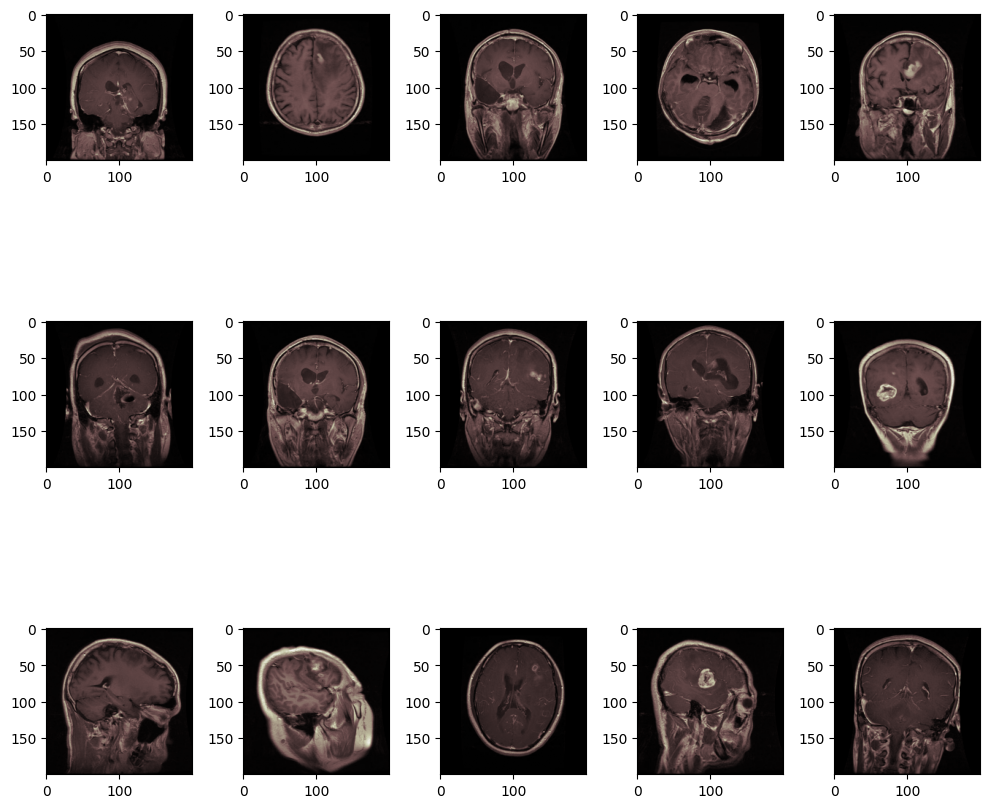

In [13]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

## Poission


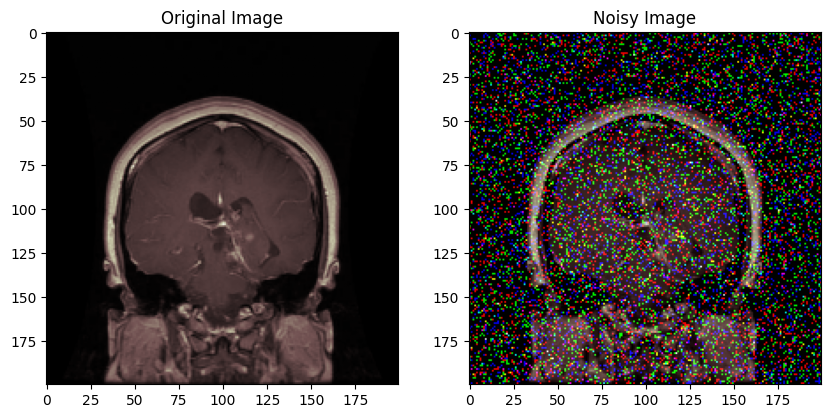

In [14]:
import numpy as np
from matplotlib import pyplot as plt

# Add very little Poisson noise to the first image in the training set
x_train_noisy = x_train.copy()
x_train_noisy[0] = np.clip(x_train[0] + np.random.poisson(lam=0.1, size=x_train[0].shape) - 0.1, 0.0, 1.0)

# Show the original image and the noisy image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_train[0])
axs[0].set_title('Original Image')
axs[1].imshow(x_train_noisy[0])
axs[1].set_title('Noisy Image')
plt.show()


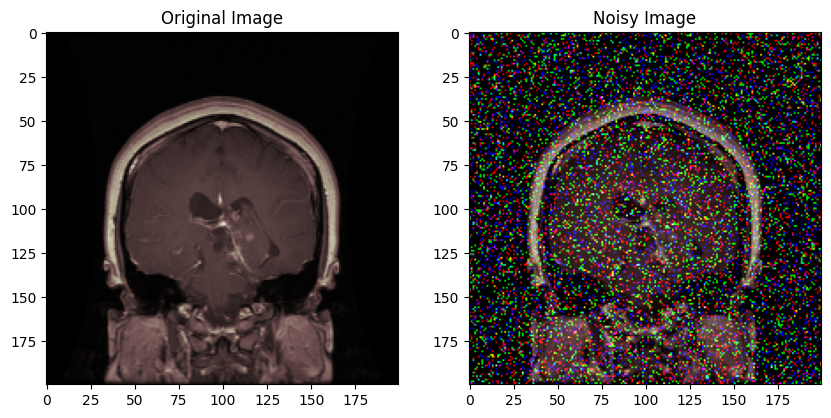

In [15]:
import numpy as np
from matplotlib import pyplot as plt

# Add very little Poisson noise to the training set
x_train_noisy = x_train.copy()
x_train_noisy = np.clip(x_train_noisy + np.random.poisson(lam=0.1, size=x_train_noisy.shape) - 0.1, 0.0, 1.0)

# Add very little Poisson noise to the test set
x_test_noisy = x_test.copy()
x_test_noisy = np.clip(x_test_noisy + np.random.poisson(lam=0.1, size=x_test_noisy.shape) - 0.1, 0.0, 1.0)

# Show the original image and the noisy image side by side for the first image in the training set
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_train[0])
axs[0].set_title('Original Image')
axs[1].imshow(x_train_noisy[0])
axs[1].set_title('Noisy Image')
plt.show()


In [16]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

# Load the saved model
model = tf.keras.models.load_model('/workspaces/Brain-Tumor-MRI-Classification/model-10-0.98-0.09.h5')

# Evaluate the model on the noisy test data
test_loss, test_acc = model.evaluate(x_test_noisy, y_test)

# Print the test accuracy
print('Test accuracy:', test_acc)

41/41 [==============================] - 40s 963ms/step - loss: 13.8718 - accuracy: 0.3089
Test accuracy: 0.30892449617385864


41/41 [==============================] - 41s 972ms/step


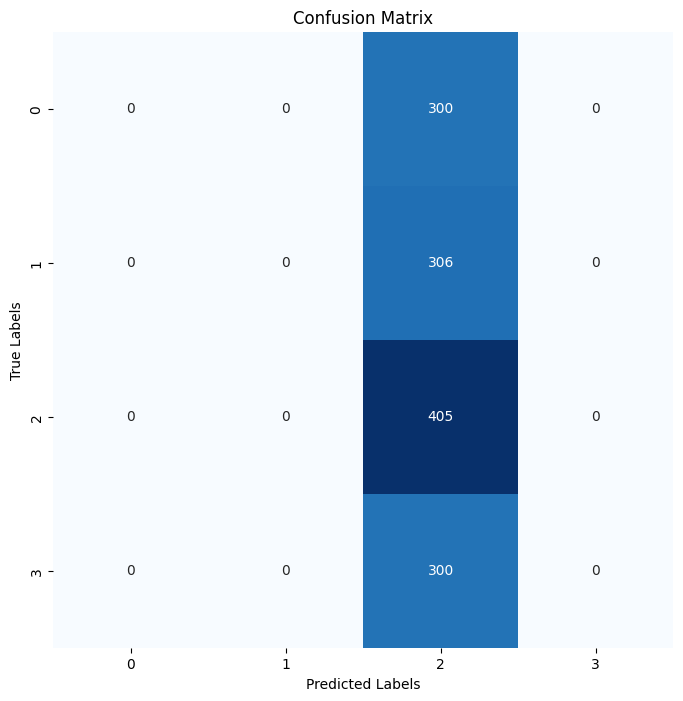

In [17]:
# Extract the predicted labels
y_pred = model.predict(x_test_noisy)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
#combine x_train and x_train_noisy and y_train and y_train
x_train = np.concatenate((x_train, x_train_noisy), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [19]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/5
286/286 [==============================] - 1502s 5s/step - loss: 0.0811 - accuracy: 0.7812 - val_loss: 0.1357 - val_accuracy: 0.6635
Epoch 2/5
286/286 [==============================] - 1456s 5s/step - loss: 0.0365 - accuracy: 0.9020 - val_loss: 0.0865 - val_accuracy: 0.7864
Epoch 3/5
286/286 [==============================] - 1449s 5s/step - loss: 0.0332 - accuracy: 0.9154 - val_loss: 0.1007 - val_accuracy: 0.7527
Epoch 4/5
286/286 [==============================] - 1447s 5s/step - loss: 0.0271 - accuracy: 0.9330 - val_loss: 0.0309 - val_accuracy: 0.9247
Epoch 5/5
286/286 [==============================] - 1439s 5s/step - loss: 0.0200 - accuracy: 0.9487 - val_loss: 0.2172 - val_accuracy: 0.5142


41/41 [==============================] - 36s 876ms/step


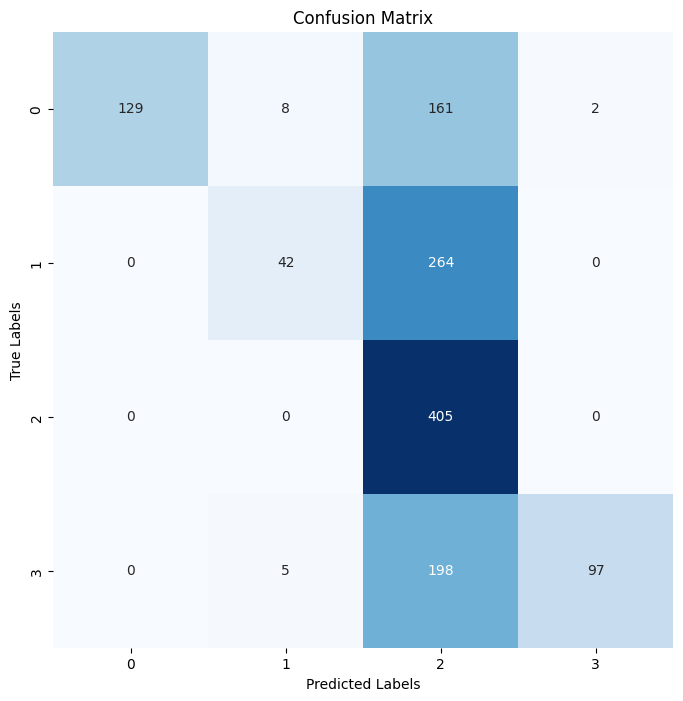

In [24]:

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

41/41 [==============================] - 36s 878ms/step


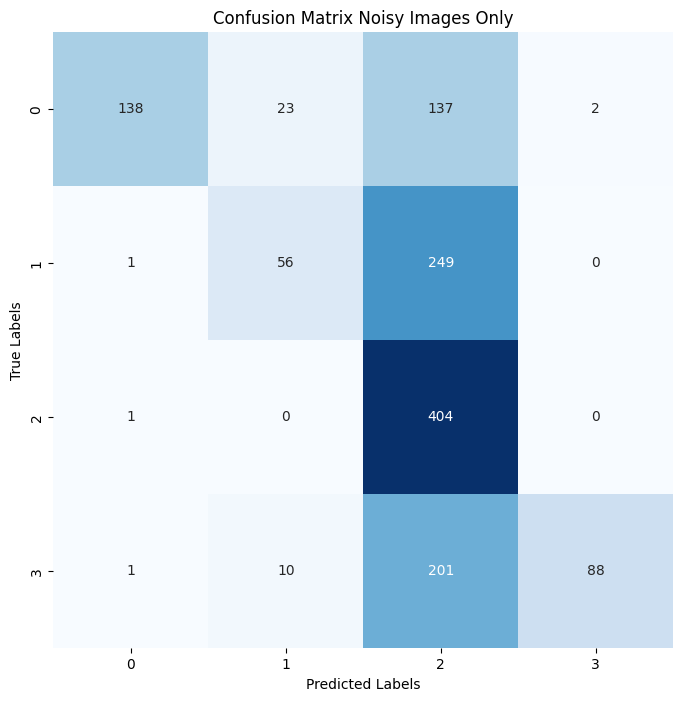

In [21]:
# Extract the predicted labels
y_pred = model.predict(x_test_noisy)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Noisy Images Only')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()